In [1]:
%matplotlib inline
import warnings
warnings. filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib. pyplot as plt
import seaborn as sns
from sklearn. feature_extraction. text import TfidfTransformer
from sklearn. feature_extraction. text import TfidfVectorizer
from sklearn. feature_extraction. text import CountVectorizer
from sklearn. metrics import confusion_matrix
from sklearn import metrics
from sklearn. metrics import roc_curve, auc
from nltk. stem. porter import PorterStemmer
import re
import string
from nltk. corpus import stopwords
from nltk. stem import PorterStemmer
from nltk. stem. wordnet import WordNetLemmatizer
from gensim. models import Word2Vec
from gensim. models import KeyedVectors
import pickle
import scipy as sp
from tqdm import tqdm
import os
from sklearn. cross_validation import train_test_split
from sklearn. neighbors import KNeighborsClassifier
from sklearn. metrics import accuracy_score
from sklearn. cross_validation import cross_val_score
from collections import Counter
from sklearn. metrics import accuracy_score
from sklearn import cross_validation
from sklearn. metrics import confusion_matrix
from sklearn. preprocessing import normalize
from sklearn import datasets, neighbors
from sklearn. metrics import roc_auc_score
from sklearn. preprocessing import StandardScaler

C:\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# [0] <font color='red'>Load Data

In [2]:
from scipy.sparse import load_npz

path = "C:/Python/Assignments/Preprocessing/"

train_bow = load_npz(path + "train_bow.npz")
test_bow = load_npz(path + "test_bow.npz")
cv_bow = load_npz(path + "cv_bow.npz")

train_tfidf = load_npz(path + "train_tfidf.npz")
test_tfidf = load_npz(path + "test_tfidf.npz")
cv_tfidf = load_npz(path + "cv_tfidf.npz")

with open("C:\Python\Assignments\Preprocessing\X_test.txt", "rb") as file:
    X_test = pickle.load(file)
with open("C:\Python\Assignments\Preprocessing\X_train.txt", "rb") as file:
    X_train = pickle.load(file)
with open("C:\Python\Assignments\Preprocessing\X_cv.txt", "rb") as file:
    X_cv = pickle.load(file)
    
with open("C:\Python\Assignments\Preprocessing\Y_test.txt", "rb") as file:
    Y_test = pickle.load(file)
with open("C:\Python\Assignments\Preprocessing\Y_train.txt", "rb") as file:
    Y_train = pickle.load(file)
with open("C:\Python\Assignments\Preprocessing\Y_cv.txt", "rb") as file:
    Y_cv = pickle.load(file)

with open(path + "X_cv_sum.txt", "rb") as file:
    X_cv_sum = pickle.load(file)
with open(path + "X_train_sum.txt", "rb") as file:
    X_train_sum = pickle.load(file)
with open(path + "X_test_sum.txt", "rb") as file:
    X_test_sum = pickle.load(file)

# NB Function

In [3]:
from sklearn.naive_bayes import MultinomialNB
def nb_all(train,test,cv):
    #Calculation NB for different k values
    auc_train = []
    auc_cv = []
    a = np.arange(0.0001,2,0.001)
    print("Starting classifier...")
    for i in tqdm(a):
        NB = MultinomialNB(alpha=i)
        NB.fit(train,Y_train)

        pred_prob = NB.predict_proba(cv)
        pred_prob_train = NB.predict_proba(train)

        #acc = accuracy_score(Y_cv, pred, normalize=True) * float(100)
        auc_cv.append(roc_auc_score(Y_cv, pred_prob[:,1]))
        auc_train.append(roc_auc_score(Y_train, pred_prob_train[:,1]))

    #Plotting the AUC curve for train and test data

    #Print the graph

    plt.plot(a,auc_train,'r', label = 'Train Data')
    plt.plot(a,auc_cv,'b', label = 'CV Data')
    plt.ylim(0,1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.grid(True)
    plt.title("AUC Values for Train and CV Data\n")
    plt.xlabel("Hyper Parameter(alpha)")
    plt.ylabel("AUC Value")
    plt.show()


    #Get k value for max auc in cv data
    mx = 0
    for i in range(len(auc_cv)):
        if(auc_cv[i]> auc_cv[mx]):
            mx = i
    opt = a[mx] 
    print("The optimal value of alpha = ", opt)

    #print("\nClassifying Test Data\n\n")
    NB = MultinomialNB(alpha=opt)
    NB.fit(train,Y_train)
    pred_prob = NB.predict_proba(test)

    print("\nThe AUC value for test data is ",roc_auc_score(Y_test, pred_prob[:,1]))


## Calculate Helpfulness percentage to add as a feature

In [4]:
# Get the helpfulness data
with open(path + "final_sorted.txt", "rb") as file:
    sorted_data = pickle.load(file)

In [5]:
my_final = sorted_data[:100000]
my_final['Helpful_percent'] = (my_final['HelpfulnessNumerator'] / my_final['HelpfulnessDenominator'])*100
my_final['Helpful_percent'].fillna(0, inplace=True)

In [6]:
from sklearn.model_selection import train_test_split
x = my_final['Helpful_percent'].values
y = my_final['Score']

# split the data set into train and test
X_1, X_test_perc, y_1, Y_test1 = cross_validation.train_test_split(x, y, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
X_train_perc, X_cv_perc, Y_train1, Y_cv1 = cross_validation.train_test_split(X_1, y_1, test_size=0.3,random_state=0)

In [7]:
# https://stackoverflow.com/questions/41927781/adding-pandas-columns-to-a-sparse-matrix/41948136
from scipy.sparse import hstack
def addmat(col,csr_mat):
    '''
    Add a new column to sarse matrix with the number of words in each entry of col
    '''
    leng = []
    for i in col:
        leng.append(len(i.split(" ")))
    train_bow = hstack((csr_mat,pd.Series(leng)[:,None]))
    return train_bow.tocsr()

# BoW

With review text and summary both


Starting classifier...


100%|██████████████████████████████████████| 2000/2000 [02:50<00:00, 12.15it/s]


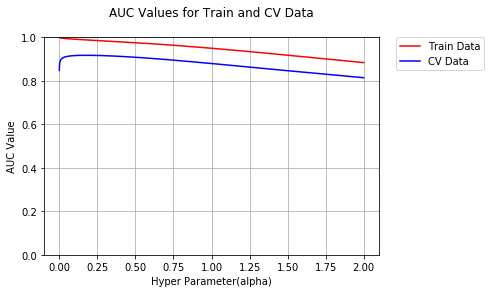

The optimal value of alpha =  0.1751

The AUC value for test data is  0.9131619486669684
With review text length


Starting classifier...


100%|██████████████████████████████████████| 2000/2000 [03:01<00:00, 11.87it/s]


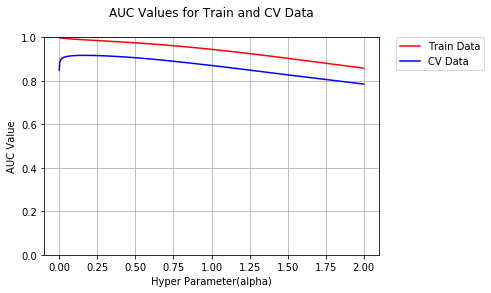

The optimal value of alpha =  0.1691

The AUC value for test data is  0.9129352339504304


With review summary length


Starting classifier...


100%|██████████████████████████████████████| 2000/2000 [03:03<00:00, 10.89it/s]


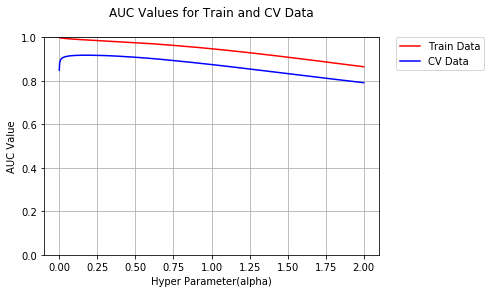

The optimal value of alpha =  0.17609999999999998

The AUC value for test data is  0.913805855967981


With helpfullness percentage


Starting classifier...


100%|██████████████████████████████████████| 2000/2000 [04:10<00:00,  8.26it/s]


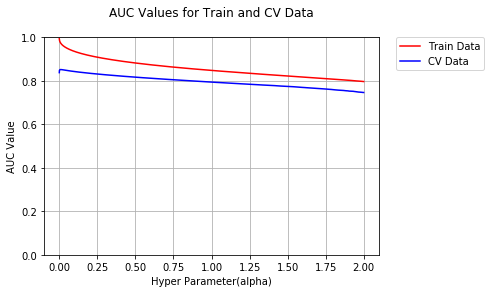

The optimal value of alpha =  0.0101

The AUC value for test data is  0.8528869578686413


In [9]:
#Adding review text and review summary to create a new data
train = X_train + X_train_sum
cv = X_cv + X_cv_sum
test = X_test + X_test_sum

#BoW

count_vect = CountVectorizer() #in scikit-learn
train_vect = count_vect.fit_transform(train)
cv_vect = count_vect.transform(cv)
ts_vect = count_vect.transform(test)
print("With review text and summary both\n\n")

nb_all(train_vect,ts_vect,cv_vect)
print("With review text length\n\n")
# Adding the number of words each review text as a new feature
tr1 = addmat(X_train,train_vect)
cv1 = addmat(X_cv,cv_vect)
ts1 = addmat(X_test,ts_vect)
nb_all(tr1,ts1,cv1)
print("\n\nWith review summary length\n\n")
# Adding the number of words each review summary as a new feature
tr1 = addmat(X_train_sum,tr1)
cv1 = addmat(X_cv_sum,cv1)
ts1 = addmat(X_test_sum,ts1)

nb_all(tr1,ts1,cv1)
print("\n\nWith helpfullness percentage\n\n")
# Adding Helpfulness Percentage as a new feature
tr1 = hstack((tr1,pd.Series(X_train_perc)[:,None]))
cv1 = hstack((cv1,pd.Series(X_cv_perc)[:,None]))
ts1 = hstack((ts1,pd.Series(X_test_perc)[:,None]))
nb_all(tr1,ts1,cv1)

# TFIDF

With review text and summary both


Starting classifier...


100%|██████████████████████████████████████| 2000/2000 [02:20<00:00, 14.29it/s]


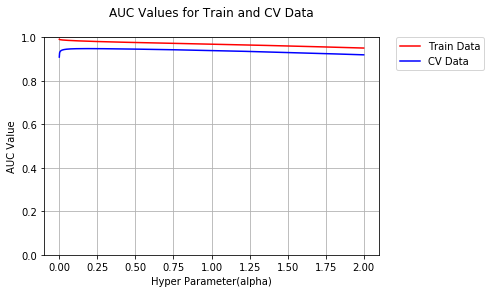

The optimal value of alpha =  0.18009999999999998

The AUC value for test data is  0.9464880225429979
With review text length


Starting classifier...


100%|██████████████████████████████████████| 2000/2000 [02:28<00:00, 13.24it/s]


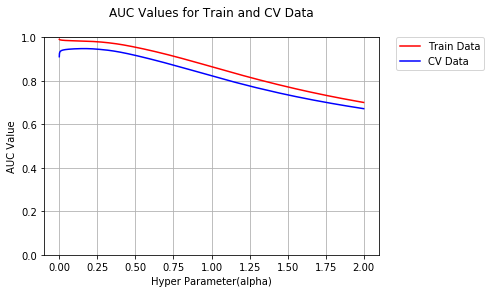

The optimal value of alpha =  0.1651

The AUC value for test data is  0.9464537490633202


With review summary length


Starting classifier...


100%|██████████████████████████████████████| 2000/2000 [02:30<00:00, 13.20it/s]


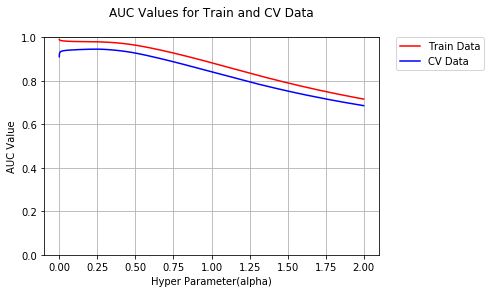

The optimal value of alpha =  0.2391

The AUC value for test data is  0.9440714106805715


With helpfullness percentage


Starting classifier...


100%|██████████████████████████████████████| 2000/2000 [04:30<00:00,  7.43it/s]


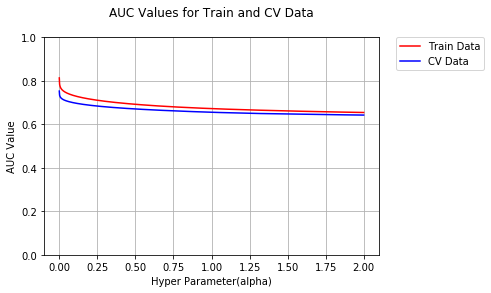

The optimal value of alpha =  0.0001

The AUC value for test data is  0.7617421143411149


In [10]:
# TfIdf
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
train_vect = tf_idf_vect.fit_transform(train)
cv_vect = tf_idf_vect.transform(cv)
ts_vect = tf_idf_vect.transform(test)
print("With review text and summary both\n\n")

nb_all(train_vect,ts_vect,cv_vect)
print("With review text length\n\n")
# Adding the number of words each review text as a new feature
tr1 = addmat(X_train,train_vect)
cv1 = addmat(X_cv,cv_vect)
ts1 = addmat(X_test,ts_vect)
nb_all(tr1,ts1,cv1)
print("\n\nWith review summary length\n\n")
# Adding the number of words each review summary as a new feature
tr1 = addmat(X_train_sum,tr1)
cv1 = addmat(X_cv_sum,cv1)
ts1 = addmat(X_test_sum,ts1)

nb_all(tr1,ts1,cv1)
print("\n\nWith helpfullness percentage\n\n")
# Adding Helpfulness Percentage as a new feature
tr1 = hstack((tr1,pd.Series(X_train_perc)[:,None]))
cv1 = hstack((cv1,pd.Series(X_cv_perc)[:,None]))
ts1 = hstack((ts1,pd.Series(X_test_perc)[:,None]))
nb_all(tr1,ts1,cv1)

# Conclusion

In [1]:
# Please compare all your models using Prettytable library
from prettytable import from_csv
with open("added.csv", "r") as fp: 
    x = from_csv(fp)
    
print(x)

+------------+--------------------------------+--------+-----------+
| Vectorizer |       New Feature Added        | Alpha  | AUC Value |
+------------+--------------------------------+--------+-----------+
|    BOW     |        Only Review Text        | 0.3801 |    0.9    |
|    BOW     | Review Summary along with Text | 0.1751 |    0.91   |
|    BOW     |       Review text length       | 0.1691 |    0.91   |
|    BOW     |     Review summary length      | 0.1761 |    0.91   |
|    BOW     |     Helpfulness Percentage     | 0.0101 |    0.85   |
|   TFIDF    |        Only Review Text        | 0.2201 |    0.95   |
|   TFIDF    | Review Summary along with Text | 0.1801 |    0.95   |
|   TFIDF    |       Review text length       | 0.1651 |    0.95   |
|   TFIDF    |     Review summary length      | 0.2391 |    0.95   |
|   TFIDF    |     Helpfulness Percentage     | 0.0001 |    0.76   |
+------------+--------------------------------+--------+-----------+


1. The result I got only with review text with BOW, got slightly increased when I added review summary and review lengths.
2. But when I took helpfulness percentage, the moel showed less AUC value, so clearly helpfulness parameter is not a good feature to consider, for this data.
3. With TFIDF the results were same even after adding new features, but it got less AUC value for helpfulness percentage.
4. Finally we can say the model can be improved a little if we take review text into consideration also.